<a href="https://colab.research.google.com/github/BelousovIM/Projects/blob/main/Mountain_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import gym
import torch.nn as nn
import torch
from torch import optim
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

In [2]:
def create_new_model():
    model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 3)
    )
    target_model = copy.deepcopy(model)

    model.to(device)
    target_model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.00003)
    
    return model, target_model, optimizer

In [3]:
def fit(batch, model, target_model, optimizer):
    state, action, reward, next_state, done = batch

    state = torch.tensor(state).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    reward = torch.tensor(reward).to(device).float()
    action = torch.tensor(action).to(device)

    target_q = torch.zeros(reward.size()[0]).float().to(device)

    with torch.no_grad():
        target_q[done] = target_model(next_state).max(1)[0].detach()
    target_q = reward + target_q * gamma

    q = model(state).gather(1, action.unsqueeze(1))

    loss = F.mse_loss(q, target_q.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [4]:
def select_action(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
    return model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()

In [5]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, element):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return list(zip(*random.sample(self.memory, batch_size)))
    
    def __len__(self):
        return len(self.memory)

In [6]:
def train(env):
      memory = Memory(5000)
      model, target_model, optimizer = create_new_model()
      state = env.reset()
      rewards_by_target_updates = []

      for step in tqdm_notebook(range(max_steps)):
        epsilon = max_epsilon - (max_epsilon - min_epsilon) * step / max_steps
        action = select_action(state, epsilon, model)
        new_state, reward, done, _ = env.step(action)
        # modified_reward = reward 
        # modified_reward = reward + 10 * abs(new_state[1])
        modified_reward = reward + 300 * (gamma * abs(new_state[1]) - abs(state[1]))

        memory.push((state, action, modified_reward, new_state, done))
        if done:
            state = env.reset()
            done = False
        else:
            state = new_state

        if step > batch_size:
            fit(memory.sample(batch_size), model, target_model, optimizer)

        if step % target_update == 0:
            target_model = copy.deepcopy(model)

            state = env.reset()
            total_reward = 0
            while not done:
                action = select_action(state, 0, model)
                state, reward, done, _ = env.step(action)
                total_reward += reward

            done = False
            state = env.reset()
            rewards_by_target_updates.append(total_reward)
      plt.plot(rewards_by_target_updates)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


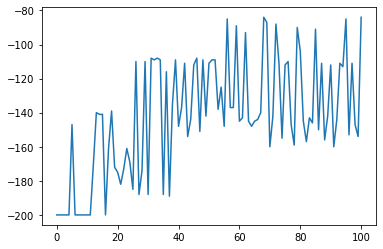

In [8]:
env = gym.make("MountainCar-v0")

device = torch.device("cuda")

target_update = 1000
batch_size = 128
max_epsilon = 0.5
min_epsilon = 0.1

max_steps = 100000 + 1

gamma = 0.99

train(env)